# Paddy Pro: A MobilenetV3 Based App to Recognize Paddy Leaf Diseases<a
href="#Paddy-Pro:-A-MobilenetV3-Based-App-to-Recognize-Paddy-Leaf-Diseases"
class="anchor-link">¶</a>

In \[1\]:

    #Importing necessary packages
    import tensorflow as tf
    from tensorflow.keras import models, layers
    import matplotlib.pyplot as plt

In \[42\]:

    #set the constants
    BATCH_SIZE = 32
    IMAGE_SIZE = 256
    CHANNELS=3
    EPOCHS=50

### Load dataset into TF data input pipeline<a href="#Load-dataset-into-TF-data-input-pipeline"
class="anchor-link">¶</a>

In \[43\]:

    #import data as tensorflow dataset object
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        "Dataset",
        seed=123,
        shuffle=True,
        image_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )

    Found 3451 files belonging to 5 classes.

In \[44\]:

    class_names = dataset.class_names
    class_names

Out\[44\]:

    ['BacterialLeafBlight', 'BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']

### Data Visualisation<a href="#Data-Visualisation" class="anchor-link">¶</a>

In \[45\]:

    for image_batch, labels_batch in dataset.take(1):
        print(image_batch.shape)
        print(labels_batch.numpy())

    (32, 256, 256, 3)
    [2 2 4 2 2 2 4 2 4 0 2 3 3 4 2 2 2 4 3 2 4 2 3 4 2 2 2 0 2 2 4 2]

In \[46\]:

    plt.figure(figsize=(10, 10))
    for image_batch, labels_batch in dataset.take(1):
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[labels_batch[i]])
            plt.axis("off")

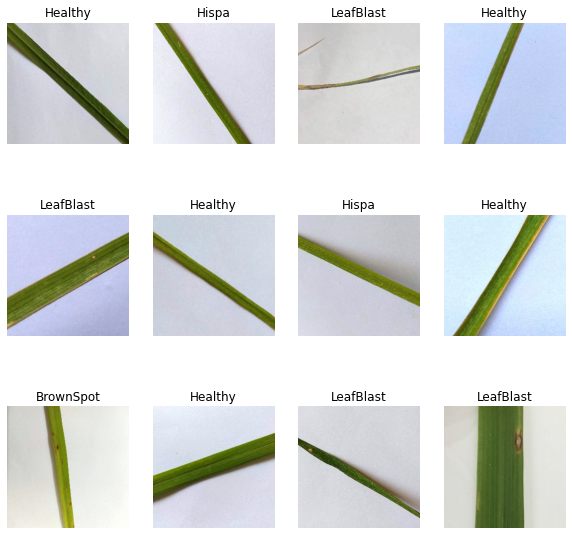

### Train Test Split<a href="#Train-Test-Split" class="anchor-link">¶</a>

##### Training - 80%, Validation - 10%, Testing - 10%<a href="#Training----80%25,-Validation---10%25,-Testing---10%25"
class="anchor-link">¶</a>

In \[47\]:

    def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
        assert (train_split + test_split + val_split) == 1
        
        ds_size = len(ds)
        
        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
        
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)
        
        train_ds = ds.take(train_size)    
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
        
        return train_ds, val_ds, test_ds

In \[48\]:

    train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In \[49\]:

    len(train_ds)

Out\[49\]:

    86

In \[50\]:

    len(val_ds)

Out\[50\]:

    10

In \[51\]:

    len(test_ds)

Out\[51\]:

    12

### Data Augmentation<a href="#Data-Augmentation" class="anchor-link">¶</a>

In \[52\]:

    # cache, shuffle, prefetch to improve the performance of cpu and gpu
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In \[53\]:

    #Resizing and normalization for initial layers of model
    resize_and_rescale = tf.keras.Sequential([
      layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
      layers.experimental.preprocessing.Rescaling(1./255),
    ])

In \[54\]:

    data_augmentation = tf.keras.Sequential(
      [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(0.1),
      ]
    )

In \[55\]:

    plt.imshow(image_batch[1].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[1]])
    plt.axis("off")

Out\[55\]:

    (-0.5, 255.5, 255.5, -0.5)

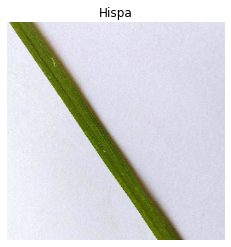

In \[16\]:

    plt.imshow(data_augmentation(image_batch)[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[1]])
    plt.axis("off")

Out\[16\]:

    (-0.5, 223.5, 223.5, -0.5)

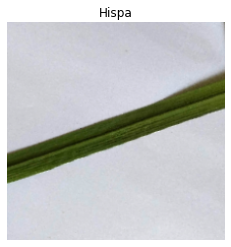

### Building Model - CNN<a href="#Building-Model---CNN" class="anchor-link">¶</a>

###### CNN coupled with Softmax activation in output layer and resizing, Normalization in initial layers<a
href="#CNN-coupled-with-Softmax-activation-in-output-layer-and-resizing,-Normalization-in-initial-layers"
class="anchor-link">¶</a>

In \[ \]:

    input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    n_classes = 5

    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
    ])

    model.build(input_shape=input_shape)

In \[39\]:

    model.summary()

    Model: "sequential_5"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    sequential (Sequential)      (None, 256, 256, 3)       0         
    _________________________________________________________________
    conv2d_12 (Conv2D)           (32, 254, 254, 32)        896       
    _________________________________________________________________
    max_pooling2d_12 (MaxPooling (32, 127, 127, 32)        0         
    _________________________________________________________________
    conv2d_13 (Conv2D)           (32, 125, 125, 64)        18496     
    _________________________________________________________________
    max_pooling2d_13 (MaxPooling (32, 62, 62, 64)          0         
    _________________________________________________________________
    conv2d_14 (Conv2D)           (32, 60, 60, 64)          36928     
    _________________________________________________________________
    max_pooling2d_14 (MaxPooling (32, 30, 30, 64)          0         
    _________________________________________________________________
    conv2d_15 (Conv2D)           (32, 28, 28, 64)          36928     
    _________________________________________________________________
    max_pooling2d_15 (MaxPooling (32, 14, 14, 64)          0         
    _________________________________________________________________
    conv2d_16 (Conv2D)           (32, 12, 12, 64)          36928     
    _________________________________________________________________
    max_pooling2d_16 (MaxPooling (32, 6, 6, 64)            0         
    _________________________________________________________________
    conv2d_17 (Conv2D)           (32, 4, 4, 64)            36928     
    _________________________________________________________________
    max_pooling2d_17 (MaxPooling (32, 2, 2, 64)            0         
    _________________________________________________________________
    flatten_2 (Flatten)          (32, 256)                 0         
    _________________________________________________________________
    dense_4 (Dense)              (32, 64)                  16448     
    _________________________________________________________________
    dense_5 (Dense)              (32, 5)                   325       
    =================================================================
    Total params: 183,877
    Trainable params: 183,877
    Non-trainable params: 0
    _________________________________________________________________

#### Compiling the model<a href="#Compiling-the-model" class="anchor-link">¶</a>

###### Adam optimizer and SparseCategoricalCrossEntropy for losses<a href="#Adam-optimizer-and-SparseCategoricalCrossEntropy-for-losses"
class="anchor-link">¶</a>

In \[40\]:

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

### Training Model<a href="#Training-Model" class="anchor-link">¶</a>

In \[41\]:

    history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1,
        epochs=50,
    )

    Epoch 1/50
    86/86 [==============================] - 610s 7s/step - loss: 1.3308 - accuracy: 0.4285 - val_loss: 1.1818 - val_accuracy: 0.5344
    Epoch 2/50
    86/86 [==============================] - 158s 2s/step - loss: 1.2390 - accuracy: 0.4765 - val_loss: 1.1147 - val_accuracy: 0.5500
    Epoch 3/50
    86/86 [==============================] - 113s 1s/step - loss: 1.1673 - accuracy: 0.5056 - val_loss: 1.0572 - val_accuracy: 0.5656
    Epoch 4/50
    86/86 [==============================] - 114s 1s/step - loss: 1.1382 - accuracy: 0.5140 - val_loss: 1.0848 - val_accuracy: 0.5531
    Epoch 5/50
    86/86 [==============================] - 146s 2s/step - loss: 1.1041 - accuracy: 0.5289 - val_loss: 1.0992 - val_accuracy: 0.5500
    Epoch 6/50
    86/86 [==============================] - 157s 2s/step - loss: 1.1006 - accuracy: 0.5344 - val_loss: 1.1839 - val_accuracy: 0.5031
    Epoch 7/50
    86/86 [==============================] - 157s 2s/step - loss: 1.0818 - accuracy: 0.5402 - val_loss: 0.9945 - val_accuracy: 0.5938
    Epoch 8/50
    86/86 [==============================] - 138s 2s/step - loss: 1.0378 - accuracy: 0.5471 - val_loss: 0.9822 - val_accuracy: 0.6031
    Epoch 9/50
    86/86 [==============================] - 133s 2s/step - loss: 1.0605 - accuracy: 0.5482 - val_loss: 1.0253 - val_accuracy: 0.6187
    Epoch 10/50
    86/86 [==============================] - 155s 2s/step - loss: 1.0299 - accuracy: 0.5668 - val_loss: 0.9936 - val_accuracy: 0.6031
    Epoch 11/50
    86/86 [==============================] - 147s 2s/step - loss: 1.0183 - accuracy: 0.5672 - val_loss: 1.0383 - val_accuracy: 0.5875
    Epoch 12/50
    86/86 [==============================] - 124s 1s/step - loss: 1.0054 - accuracy: 0.5672 - val_loss: 0.9558 - val_accuracy: 0.6156
    Epoch 13/50
    86/86 [==============================] - 136s 2s/step - loss: 0.9941 - accuracy: 0.5828 - val_loss: 0.9624 - val_accuracy: 0.6250
    Epoch 14/50
    86/86 [==============================] - 142s 2s/step - loss: 0.9696 - accuracy: 0.5945 - val_loss: 0.9534 - val_accuracy: 0.6062
    Epoch 15/50
    86/86 [==============================] - 158s 2s/step - loss: 0.9577 - accuracy: 0.5988 - val_loss: 0.9593 - val_accuracy: 0.6031
    Epoch 16/50
    86/86 [==============================] - 157s 2s/step - loss: 0.9241 - accuracy: 0.6145 - val_loss: 0.9079 - val_accuracy: 0.6438
    Epoch 17/50
    86/86 [==============================] - 152s 2s/step - loss: 0.9090 - accuracy: 0.6229 - val_loss: 0.8652 - val_accuracy: 0.6656
    Epoch 18/50
    86/86 [==============================] - 115s 1s/step - loss: 0.9008 - accuracy: 0.6247 - val_loss: 0.8431 - val_accuracy: 0.6500
    Epoch 19/50
    86/86 [==============================] - 112s 1s/step - loss: 0.8619 - accuracy: 0.6440 - val_loss: 0.8874 - val_accuracy: 0.6219
    Epoch 20/50
    86/86 [==============================] - 122s 1s/step - loss: 0.8445 - accuracy: 0.6400 - val_loss: 0.8605 - val_accuracy: 0.6281
    Epoch 21/50
    86/86 [==============================] - 125s 1s/step - loss: 0.8254 - accuracy: 0.6578 - val_loss: 0.8093 - val_accuracy: 0.6750
    Epoch 22/50
    86/86 [==============================] - 122s 1s/step - loss: 0.7775 - accuracy: 0.6756 - val_loss: 0.7211 - val_accuracy: 0.7156
    Epoch 23/50
    86/86 [==============================] - 120s 1s/step - loss: 0.7274 - accuracy: 0.6982 - val_loss: 0.7345 - val_accuracy: 0.7031
    Epoch 24/50
    86/86 [==============================] - 123s 1s/step - loss: 0.6955 - accuracy: 0.7142 - val_loss: 0.7771 - val_accuracy: 0.7188
    Epoch 25/50
    86/86 [==============================] - 120s 1s/step - loss: 0.7622 - accuracy: 0.6928 - val_loss: 0.7053 - val_accuracy: 0.7375
    Epoch 26/50
    86/86 [==============================] - 121s 1s/step - loss: 0.6475 - accuracy: 0.7397 - val_loss: 0.6990 - val_accuracy: 0.7406
    Epoch 27/50
    86/86 [==============================] - 119s 1s/step - loss: 0.6016 - accuracy: 0.7455 - val_loss: 0.5931 - val_accuracy: 0.7937
    Epoch 28/50
    86/86 [==============================] - 114s 1s/step - loss: 0.5661 - accuracy: 0.7627 - val_loss: 0.6548 - val_accuracy: 0.7688
    Epoch 29/50
    86/86 [==============================] - 112s 1s/step - loss: 0.5093 - accuracy: 0.7849 - val_loss: 0.5638 - val_accuracy: 0.7719
    Epoch 30/50
    86/86 [==============================] - 115s 1s/step - loss: 0.5031 - accuracy: 0.7950 - val_loss: 0.7237 - val_accuracy: 0.7094
    Epoch 31/50
    86/86 [==============================] - 112s 1s/step - loss: 0.4733 - accuracy: 0.8027 - val_loss: 0.6234 - val_accuracy: 0.7656
    Epoch 32/50
    86/86 [==============================] - 114s 1s/step - loss: 0.4243 - accuracy: 0.8333 - val_loss: 0.6108 - val_accuracy: 0.7969
    Epoch 33/50
    86/86 [==============================] - 113s 1s/step - loss: 0.3809 - accuracy: 0.8511 - val_loss: 0.5230 - val_accuracy: 0.8313
    Epoch 34/50
    86/86 [==============================] - 112s 1s/step - loss: 0.3584 - accuracy: 0.8544 - val_loss: 0.5427 - val_accuracy: 0.8500
    Epoch 35/50
    86/86 [==============================] - 112s 1s/step - loss: 0.3148 - accuracy: 0.8810 - val_loss: 0.4878 - val_accuracy: 0.8469
    Epoch 36/50
    86/86 [==============================] - 112s 1s/step - loss: 0.2704 - accuracy: 0.8930 - val_loss: 0.6355 - val_accuracy: 0.8313
    Epoch 37/50
    86/86 [==============================] - 113s 1s/step - loss: 0.2806 - accuracy: 0.8955 - val_loss: 0.5386 - val_accuracy: 0.8188
    Epoch 38/50
    86/86 [==============================] - 124s 1s/step - loss: 0.2620 - accuracy: 0.8959 - val_loss: 0.5230 - val_accuracy: 0.8500
    Epoch 39/50
    86/86 [==============================] - 122s 1s/step - loss: 0.2753 - accuracy: 0.8944 - val_loss: 0.5954 - val_accuracy: 0.8375
    Epoch 40/50
    86/86 [==============================] - 121s 1s/step - loss: 0.1937 - accuracy: 0.9268 - val_loss: 1.1300 - val_accuracy: 0.7188
    Epoch 41/50
    86/86 [==============================] - 129s 1s/step - loss: 0.3014 - accuracy: 0.8897 - val_loss: 0.5479 - val_accuracy: 0.8344
    Epoch 42/50
    86/86 [==============================] - 124s 1s/step - loss: 0.1878 - accuracy: 0.9305 - val_loss: 0.6228 - val_accuracy: 0.8813
    Epoch 43/50
    86/86 [==============================] - 118s 1s/step - loss: 0.1199 - accuracy: 0.9578 - val_loss: 0.6264 - val_accuracy: 0.8844
    Epoch 44/50
    86/86 [==============================] - 114s 1s/step - loss: 0.1709 - accuracy: 0.9403 - val_loss: 0.6636 - val_accuracy: 0.8625
    Epoch 45/50
    86/86 [==============================] - 115s 1s/step - loss: 0.2387 - accuracy: 0.9141 - val_loss: 0.6281 - val_accuracy: 0.8844
    Epoch 46/50
    86/86 [==============================] - 110s 1s/step - loss: 0.2327 - accuracy: 0.9101 - val_loss: 0.5208 - val_accuracy: 0.8656
    Epoch 47/50
    86/86 [==============================] - 119s 1s/step - loss: 0.1671 - accuracy: 0.9447 - val_loss: 0.5699 - val_accuracy: 0.8781
    Epoch 48/50
    86/86 [==============================] - 122s 1s/step - loss: 0.0454 - accuracy: 0.9854 - val_loss: 0.6520 - val_accuracy: 0.9062
    Epoch 49/50
    86/86 [==============================] - 121s 1s/step - loss: 0.0376 - accuracy: 0.9902 - val_loss: 0.6296 - val_accuracy: 0.9031
    Epoch 50/50
    86/86 [==============================] - 123s 1s/step - loss: 0.0735 - accuracy: 0.9756 - val_loss: 0.7704 - val_accuracy: 0.8656

### Accuracy and Loss<a href="#Accuracy-and-Loss" class="anchor-link">¶</a>

###### 84% Accuracy<a href="#84%25-Accuracy" class="anchor-link">¶</a>

In \[42\]:

    scores = model.evaluate(test_ds)

    12/12 [==============================] - 3s 265ms/step - loss: 0.9121 - accuracy: 0.8438

In \[43\]:

    history

Out\[43\]:

    <tensorflow.python.keras.callbacks.History at 0x292820bec40>

In \[44\]:

    history.params

Out\[44\]:

    {'verbose': 1, 'epochs': 50, 'steps': 86}

In \[45\]:

    history.history.keys()

Out\[45\]:

    dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In \[46\]:

    type(history.history['loss'])

Out\[46\]:

    list

In \[47\]:

    len(history.history['loss'])

Out\[47\]:

    50

In \[48\]:

    history.history['loss'][:5] 
    # show loss for first 5 epochs

Out\[48\]:

    [1.3307534456253052,
     1.239047646522522,
     1.1672722101211548,
     1.1381514072418213,
     1.104121208190918]

In \[49\]:

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

### Accuracy Plot<a href="#Accuracy-Plot" class="anchor-link">¶</a>

In \[32\]:

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

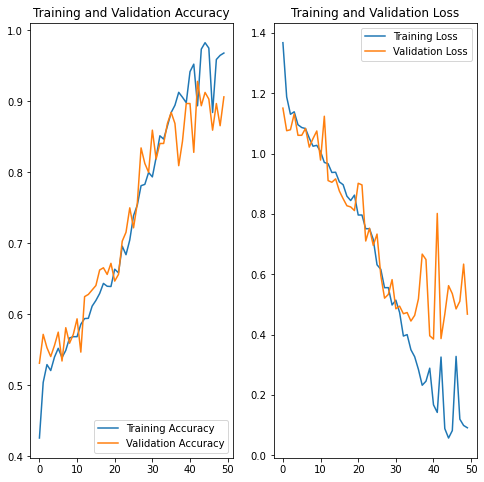

### Predictions<a href="#Predictions" class="anchor-link">¶</a>

In \[48\]:

    import numpy as np
    for images_batch, labels_batch in test_ds.take(1):
        
        first_image = images_batch[0].numpy().astype('uint8')
        first_label = labels_batch[0].numpy()
        
        print("first image to predict")
        plt.imshow(first_image)
        print("actual label:",class_names[first_label])
        
        batch_prediction = model.predict(images_batch)
        print("predicted label:",class_names[np.argmax(batch_prediction[0])])

    first image to predict
    actual label: LeafBlast
    predicted label: LeafBlast

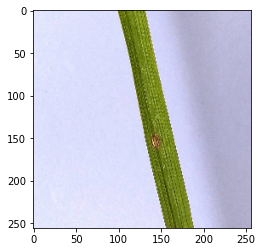

In \[52\]:

    #Inference function
    def predict(model, img):
        img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)

        predicted_class = class_names[np.argmax(predictions[0])]
        confidence = round(100 * (np.max(predictions[0])), 2)
        return predicted_class, confidence

In \[53\]:

    plt.figure(figsize=(15, 15))
    for images, labels in test_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            predicted_class, confidence = predict(model, images[i].numpy())
            actual_class = class_names[labels[i]] 
            
            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
            
            plt.axis("off")

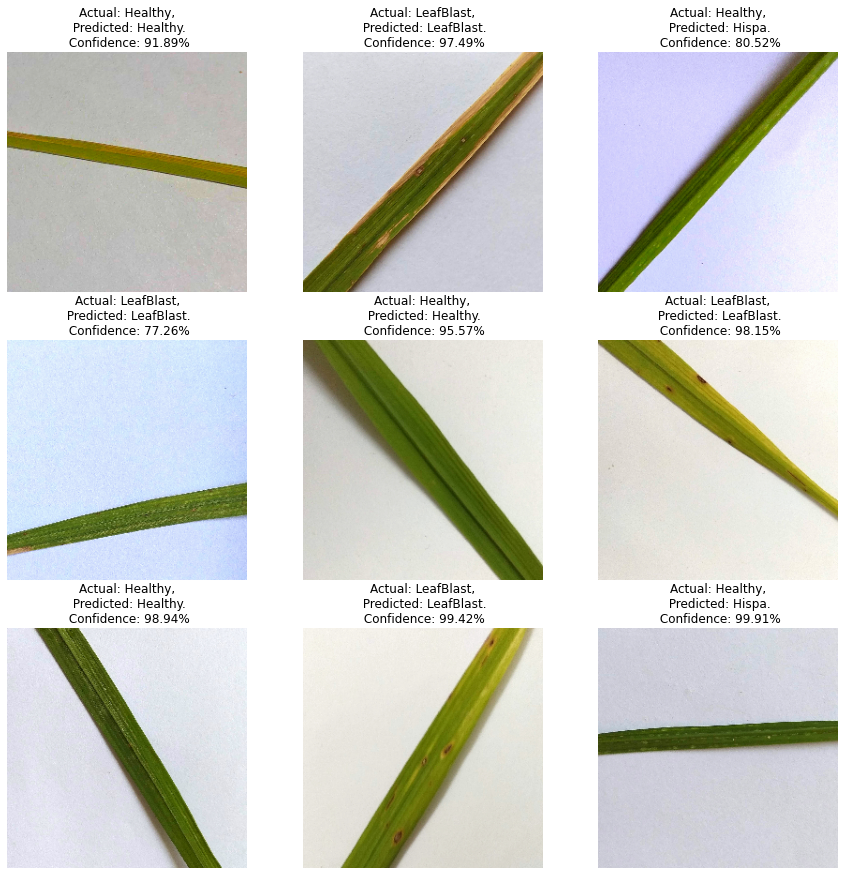

## MobileNetV3Small Model Training<a href="#MobileNetV3Small-Model-Training" class="anchor-link">¶</a>

In \[17\]:

    feature_extractor_model = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5"

    pretrained_model_without_top_layer = hub.KerasLayer(
        feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

### Transfer Learning methodology<a href="#Transfer-Learning-methodology" class="anchor-link">¶</a>

In \[18\]:

    n_classes = 5

    model = models.Sequential([
        resize_and_rescale,
        pretrained_model_without_top_layer,
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
    ])

    model.build(input_shape=(None,224,224,3))

In \[19\]:

    model.summary()

    Model: "sequential_2"
    _________________________________________________________________
     Layer (type)                Output Shape              Param #   
    =================================================================
     sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                     
     keras_layer (KerasLayer)    (None, 1001)              2555993   
                                                                     
     dense (Dense)               (None, 64)                64128     
                                                                     
     dense_1 (Dense)             (None, 5)                 325       
                                                                     
    =================================================================
    Total params: 2,620,446
    Trainable params: 64,453
    Non-trainable params: 2,555,993
    _________________________________________________________________

In \[20\]:

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

In \[23\]:

    history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1,
        epochs=50,
    )

    Epoch 1/50
    86/86 [==============================] - 21s 245ms/step - loss: 0.1563 - accuracy: 0.9505 - val_loss: 0.5086 - val_accuracy: 0.8656
    Epoch 2/50
    86/86 [==============================] - 24s 273ms/step - loss: 0.1478 - accuracy: 0.9578 - val_loss: 0.5093 - val_accuracy: 0.8719
    Epoch 3/50
    86/86 [==============================] - 24s 278ms/step - loss: 0.1483 - accuracy: 0.9578 - val_loss: 0.5667 - val_accuracy: 0.8469
    Epoch 4/50
    86/86 [==============================] - 23s 268ms/step - loss: 0.1405 - accuracy: 0.9556 - val_loss: 0.5443 - val_accuracy: 0.8656
    Epoch 5/50
    86/86 [==============================] - 24s 281ms/step - loss: 0.1477 - accuracy: 0.9519 - val_loss: 0.5394 - val_accuracy: 0.8781
    Epoch 6/50
    86/86 [==============================] - 24s 280ms/step - loss: 0.1569 - accuracy: 0.9479 - val_loss: 0.5402 - val_accuracy: 0.8656
    Epoch 7/50
    86/86 [==============================] - 24s 282ms/step - loss: 0.1322 - accuracy: 0.9567 - val_loss: 0.5252 - val_accuracy: 0.8687
    Epoch 8/50
    86/86 [==============================] - 24s 284ms/step - loss: 0.1529 - accuracy: 0.9519 - val_loss: 0.5250 - val_accuracy: 0.8594
    Epoch 9/50
    86/86 [==============================] - 25s 290ms/step - loss: 0.1406 - accuracy: 0.9519 - val_loss: 0.5517 - val_accuracy: 0.8656
    Epoch 10/50
    86/86 [==============================] - 24s 283ms/step - loss: 0.1622 - accuracy: 0.9414 - val_loss: 0.6225 - val_accuracy: 0.8438
    Epoch 11/50
    86/86 [==============================] - 24s 281ms/step - loss: 0.1242 - accuracy: 0.9603 - val_loss: 0.5743 - val_accuracy: 0.8531
    Epoch 12/50
    86/86 [==============================] - 24s 276ms/step - loss: 0.1155 - accuracy: 0.9625 - val_loss: 0.4826 - val_accuracy: 0.8969
    Epoch 13/50
    86/86 [==============================] - 25s 286ms/step - loss: 0.0981 - accuracy: 0.9712 - val_loss: 0.5544 - val_accuracy: 0.8844
    Epoch 14/50
    86/86 [==============================] - 24s 281ms/step - loss: 0.1036 - accuracy: 0.9680 - val_loss: 0.5804 - val_accuracy: 0.8781
    Epoch 15/50
    86/86 [==============================] - 24s 276ms/step - loss: 0.1011 - accuracy: 0.9665 - val_loss: 0.5586 - val_accuracy: 0.8750
    Epoch 16/50
    86/86 [==============================] - 24s 282ms/step - loss: 0.0894 - accuracy: 0.9738 - val_loss: 0.5698 - val_accuracy: 0.8750
    Epoch 17/50
    86/86 [==============================] - 24s 278ms/step - loss: 0.0761 - accuracy: 0.9840 - val_loss: 0.5323 - val_accuracy: 0.8781
    Epoch 18/50
    86/86 [==============================] - 24s 276ms/step - loss: 0.0777 - accuracy: 0.9807 - val_loss: 0.5461 - val_accuracy: 0.8875
    Epoch 19/50
    86/86 [==============================] - 23s 270ms/step - loss: 0.0895 - accuracy: 0.9760 - val_loss: 0.5882 - val_accuracy: 0.8656
    Epoch 20/50
    86/86 [==============================] - 23s 271ms/step - loss: 0.0771 - accuracy: 0.9818 - val_loss: 0.5469 - val_accuracy: 0.8844
    Epoch 21/50
    86/86 [==============================] - 24s 279ms/step - loss: 0.0809 - accuracy: 0.9752 - val_loss: 0.5438 - val_accuracy: 0.8844
    Epoch 22/50
    86/86 [==============================] - 24s 277ms/step - loss: 0.0794 - accuracy: 0.9778 - val_loss: 0.5520 - val_accuracy: 0.8969
    Epoch 23/50
    86/86 [==============================] - 23s 273ms/step - loss: 0.0687 - accuracy: 0.9836 - val_loss: 0.5884 - val_accuracy: 0.8781
    Epoch 24/50
    86/86 [==============================] - 23s 270ms/step - loss: 0.1032 - accuracy: 0.9632 - val_loss: 0.5450 - val_accuracy: 0.8844
    Epoch 25/50
    86/86 [==============================] - 23s 273ms/step - loss: 0.0607 - accuracy: 0.9880 - val_loss: 0.6193 - val_accuracy: 0.8813
    Epoch 26/50
    86/86 [==============================] - 24s 279ms/step - loss: 0.0562 - accuracy: 0.9873 - val_loss: 0.5623 - val_accuracy: 0.8938
    Epoch 27/50
    86/86 [==============================] - 23s 271ms/step - loss: 0.0454 - accuracy: 0.9934 - val_loss: 0.6638 - val_accuracy: 0.8781
    Epoch 28/50
    86/86 [==============================] - 23s 272ms/step - loss: 0.0467 - accuracy: 0.9913 - val_loss: 0.5841 - val_accuracy: 0.8969
    Epoch 29/50
    86/86 [==============================] - 24s 279ms/step - loss: 0.0548 - accuracy: 0.9862 - val_loss: 0.5561 - val_accuracy: 0.8969
    Epoch 30/50
    86/86 [==============================] - 21s 244ms/step - loss: 0.0451 - accuracy: 0.9942 - val_loss: 0.6162 - val_accuracy: 0.8875
    Epoch 31/50
    86/86 [==============================] - 20s 231ms/step - loss: 0.0609 - accuracy: 0.9840 - val_loss: 0.6727 - val_accuracy: 0.9000
    Epoch 32/50
    86/86 [==============================] - 21s 245ms/step - loss: 0.0875 - accuracy: 0.9727 - val_loss: 0.6935 - val_accuracy: 0.8469
    Epoch 33/50
    86/86 [==============================] - 23s 273ms/step - loss: 0.1521 - accuracy: 0.9494 - val_loss: 0.7682 - val_accuracy: 0.8500
    Epoch 34/50
    86/86 [==============================] - 23s 263ms/step - loss: 0.1867 - accuracy: 0.9327 - val_loss: 0.7396 - val_accuracy: 0.8531
    Epoch 35/50
    86/86 [==============================] - 23s 267ms/step - loss: 0.0871 - accuracy: 0.9720 - val_loss: 0.6857 - val_accuracy: 0.8781
    Epoch 36/50
    86/86 [==============================] - 24s 274ms/step - loss: 0.0547 - accuracy: 0.9858 - val_loss: 0.6261 - val_accuracy: 0.8906
    Epoch 37/50
    86/86 [==============================] - 24s 274ms/step - loss: 0.0575 - accuracy: 0.9825 - val_loss: 0.6238 - val_accuracy: 0.8938
    Epoch 38/50
    86/86 [==============================] - 24s 275ms/step - loss: 0.0326 - accuracy: 0.9967 - val_loss: 0.6543 - val_accuracy: 0.8875
    Epoch 39/50
    86/86 [==============================] - 23s 263ms/step - loss: 0.0297 - accuracy: 0.9967 - val_loss: 0.6622 - val_accuracy: 0.8938
    Epoch 40/50
    86/86 [==============================] - 24s 274ms/step - loss: 0.0258 - accuracy: 0.9964 - val_loss: 0.6528 - val_accuracy: 0.8906
    Epoch 41/50
    86/86 [==============================] - 23s 272ms/step - loss: 0.0222 - accuracy: 0.9982 - val_loss: 0.6630 - val_accuracy: 0.8875
    Epoch 42/50
    86/86 [==============================] - 23s 272ms/step - loss: 0.0203 - accuracy: 0.9989 - val_loss: 0.6496 - val_accuracy: 0.8969
    Epoch 43/50
    86/86 [==============================] - 24s 279ms/step - loss: 0.0233 - accuracy: 0.9985 - val_loss: 0.6682 - val_accuracy: 0.8906
    Epoch 44/50
    86/86 [==============================] - 23s 269ms/step - loss: 0.0225 - accuracy: 0.9989 - val_loss: 0.6805 - val_accuracy: 0.8844
    Epoch 45/50
    86/86 [==============================] - 23s 272ms/step - loss: 0.0178 - accuracy: 0.9996 - val_loss: 0.6641 - val_accuracy: 0.8875
    Epoch 46/50
    86/86 [==============================] - 23s 267ms/step - loss: 0.0197 - accuracy: 0.9978 - val_loss: 0.6755 - val_accuracy: 0.8938
    Epoch 47/50
    86/86 [==============================] - 23s 272ms/step - loss: 0.0194 - accuracy: 0.9982 - val_loss: 0.6711 - val_accuracy: 0.9000
    Epoch 48/50
    86/86 [==============================] - 23s 269ms/step - loss: 0.0165 - accuracy: 0.9993 - val_loss: 0.6722 - val_accuracy: 0.9000
    Epoch 49/50
    86/86 [==============================] - 23s 269ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.6771 - val_accuracy: 0.8906
    Epoch 50/50
    86/86 [==============================] - 23s 264ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.6997 - val_accuracy: 0.9000

### Accuracy<a href="#Accuracy" class="anchor-link">¶</a>

#### 93.2% Accuracy<a href="#93.2%25-Accuracy" class="anchor-link">¶</a>

In \[24\]:

    scores = model.evaluate(test_ds)

    12/12 [==============================] - 3s 260ms/step - loss: 0.4268 - accuracy: 0.9323

In \[25\]:

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

### Accuracy and Loss Plot<a href="#Accuracy-and-Loss-Plot" class="anchor-link">¶</a>

In \[26\]:

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

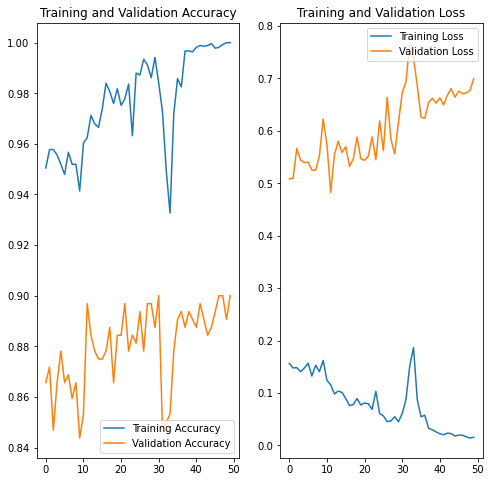

### Predictions<a href="#Predictions" class="anchor-link">¶</a>

In \[27\]:

    import numpy as np
    for images_batch, labels_batch in test_ds.take(1):
        
        first_image = images_batch[0].numpy().astype('uint8')
        first_label = labels_batch[0].numpy()
        
        print("first image to predict")
        plt.imshow(first_image)
        print("actual label:",class_names[first_label])
        
        batch_prediction = model.predict(images_batch)
        print("predicted label:",class_names[np.argmax(batch_prediction[0])])

    first image to predict
    actual label: Healthy
    predicted label: Healthy

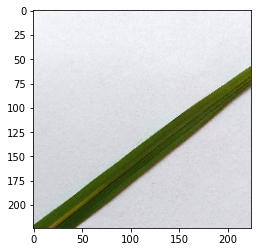

In \[28\]:

    def predict(model, img):
        img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)

        predicted_class = class_names[np.argmax(predictions[0])]
        confidence = round(100 * (np.max(predictions[0])), 2)
        return predicted_class, confidence

In \[29\]:

    plt.figure(figsize=(15, 15))
    for images, labels in test_ds.take(2):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            predicted_class, confidence = predict(model, images[i].numpy())
            actual_class = class_names[labels[i]] 
            
            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
            
            plt.axis("off")

    <ipython-input-29-2c2b6b3c3b29>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
      ax = plt.subplot(3, 3, i + 1)

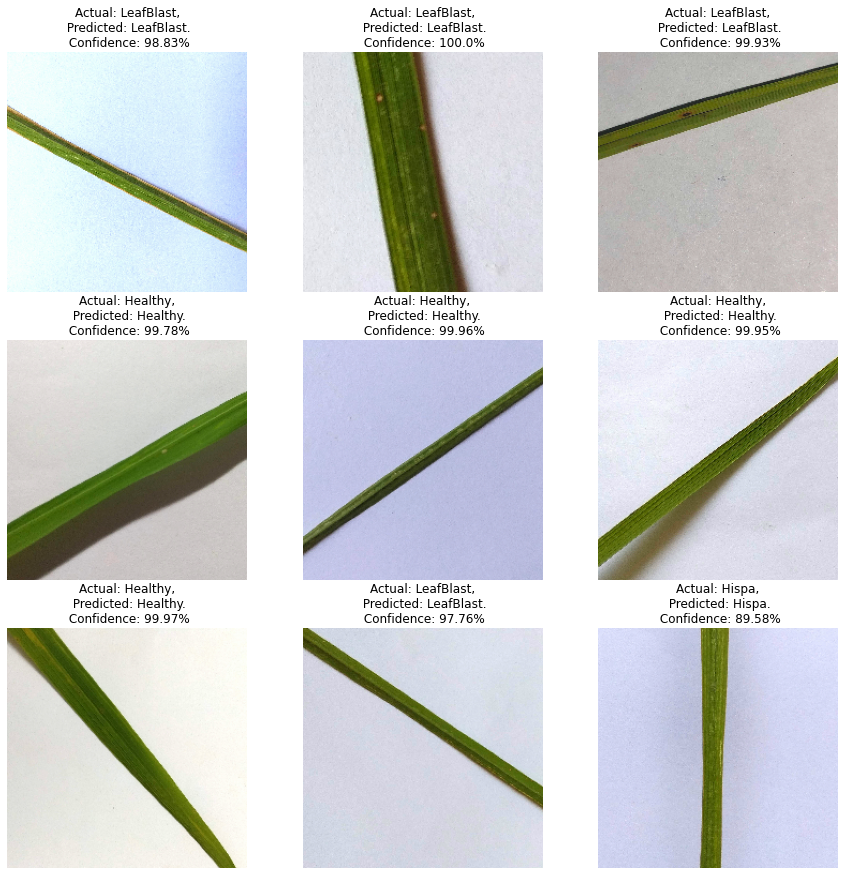

### Save the Model<a href="#Save-the-Model" class="anchor-link">¶</a>

In \[30\]:

    import os
    model.save("mobilenetv3small")

    INFO:tensorflow:Assets written to: mobilenetv3small\assets

    INFO:tensorflow:Assets written to: mobilenetv3small\assets

## MobileNetV3Large Model Training<a href="#MobileNetV3Large-Model-Training" class="anchor-link">¶</a>

In \[17\]:

    feature_extractor_model = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"

    pretrained_model_without_top_layer = hub.KerasLayer(
        feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In \[50\]:

    n_classes = 5

    model = models.Sequential([
        resize_and_rescale,
        pretrained_model_without_top_layer,
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
    ])

    model.build(input_shape=(None,224,224,3))

In \[51\]:

    model.summary()

    Model: "sequential_5"
    _________________________________________________________________
     Layer (type)                Output Shape              Param #   
    =================================================================
     sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                     
     keras_layer (KerasLayer)    (None, 1001)              5508713   
                                                                     
     dense_9 (Dense)             (None, 64)                64128     
                                                                     
     dense_10 (Dense)            (None, 5)                 325       
                                                                     
    =================================================================
    Total params: 5,573,166
    Trainable params: 64,453
    Non-trainable params: 5,508,713
    _________________________________________________________________

In \[52\]:

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

In \[90\]:

    history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1,
        epochs=50,
    )

    Epoch 1/50
    86/86 [==============================] - 41s 477ms/step - loss: 0.0097 - accuracy: 0.9982 - val_loss: 0.6939 - val_accuracy: 0.9094
    Epoch 2/50
    86/86 [==============================] - 42s 491ms/step - loss: 0.0077 - accuracy: 0.9996 - val_loss: 0.6768 - val_accuracy: 0.9062
    Epoch 3/50
    86/86 [==============================] - 41s 483ms/step - loss: 0.0072 - accuracy: 0.9996 - val_loss: 0.6821 - val_accuracy: 0.9125
    Epoch 4/50
    86/86 [==============================] - 42s 485ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.6990 - val_accuracy: 0.9094
    Epoch 5/50
    86/86 [==============================] - 41s 482ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.6864 - val_accuracy: 0.9094
    Epoch 6/50
    86/86 [==============================] - 42s 488ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.6871 - val_accuracy: 0.9125
    Epoch 7/50
    86/86 [==============================] - 42s 484ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.6758 - val_accuracy: 0.9156
    Epoch 8/50
    86/86 [==============================] - 42s 495ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.6846 - val_accuracy: 0.9094
    Epoch 9/50
    86/86 [==============================] - 43s 506ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.6886 - val_accuracy: 0.9156
    Epoch 10/50
    86/86 [==============================] - 43s 499ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.6976 - val_accuracy: 0.9125
    Epoch 11/50
    86/86 [==============================] - 42s 491ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.6923 - val_accuracy: 0.9094
    Epoch 12/50
    86/86 [==============================] - 42s 494ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.7024 - val_accuracy: 0.9062
    Epoch 13/50
    86/86 [==============================] - 42s 487ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.6839 - val_accuracy: 0.9125
    Epoch 14/50
    86/86 [==============================] - 42s 488ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.6963 - val_accuracy: 0.9062
    Epoch 15/50
    86/86 [==============================] - 42s 490ms/step - loss: 0.0083 - accuracy: 0.9985 - val_loss: 0.7320 - val_accuracy: 0.8938
    Epoch 16/50
    86/86 [==============================] - 43s 499ms/step - loss: 0.4378 - accuracy: 0.8890 - val_loss: 0.9920 - val_accuracy: 0.8313
    Epoch 17/50
    86/86 [==============================] - 42s 488ms/step - loss: 0.2178 - accuracy: 0.9297 - val_loss: 0.8393 - val_accuracy: 0.8594
    Epoch 18/50
    86/86 [==============================] - 42s 490ms/step - loss: 0.1004 - accuracy: 0.9625 - val_loss: 0.7393 - val_accuracy: 0.8938
    Epoch 19/50
    86/86 [==============================] - 42s 485ms/step - loss: 0.0275 - accuracy: 0.9920 - val_loss: 0.7029 - val_accuracy: 0.9031
    Epoch 20/50
    86/86 [==============================] - 41s 483ms/step - loss: 0.0095 - accuracy: 0.9996 - val_loss: 0.6816 - val_accuracy: 0.8969
    Epoch 21/50
    86/86 [==============================] - 42s 487ms/step - loss: 0.0077 - accuracy: 0.9996 - val_loss: 0.6842 - val_accuracy: 0.9000
    Epoch 22/50
    86/86 [==============================] - 42s 487ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.6923 - val_accuracy: 0.9031
    Epoch 23/50
    86/86 [==============================] - 43s 501ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.6900 - val_accuracy: 0.9031
    Epoch 24/50
    86/86 [==============================] - 42s 493ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.6880 - val_accuracy: 0.9062
    Epoch 25/50
    86/86 [==============================] - 42s 492ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.6802 - val_accuracy: 0.9000
    Epoch 26/50
    86/86 [==============================] - 42s 485ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.6922 - val_accuracy: 0.8969
    Epoch 27/50
    86/86 [==============================] - 42s 485ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.6913 - val_accuracy: 0.9031
    Epoch 28/50
    86/86 [==============================] - 42s 494ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.7029 - val_accuracy: 0.9031
    Epoch 29/50
    86/86 [==============================] - 43s 495ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.6944 - val_accuracy: 0.9000
    Epoch 30/50
    86/86 [==============================] - 42s 493ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.7012 - val_accuracy: 0.9000
    Epoch 31/50
    86/86 [==============================] - 41s 481ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.6981 - val_accuracy: 0.9031
    Epoch 32/50
    86/86 [==============================] - 42s 494ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.7016 - val_accuracy: 0.9062
    Epoch 33/50
    86/86 [==============================] - 42s 491ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.6994 - val_accuracy: 0.9062
    Epoch 34/50
    86/86 [==============================] - 42s 489ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.7023 - val_accuracy: 0.9031
    Epoch 35/50
    86/86 [==============================] - 42s 490ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.7180 - val_accuracy: 0.8938
    Epoch 36/50
    86/86 [==============================] - 42s 489ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.7111 - val_accuracy: 0.9031
    Epoch 37/50
    86/86 [==============================] - 42s 490ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.7114 - val_accuracy: 0.9062
    Epoch 38/50
    86/86 [==============================] - 42s 487ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.7092 - val_accuracy: 0.9000
    Epoch 39/50
    86/86 [==============================] - 43s 496ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.7148 - val_accuracy: 0.9031
    Epoch 40/50
    86/86 [==============================] - 42s 494ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.7198 - val_accuracy: 0.9031
    Epoch 41/50
    86/86 [==============================] - 43s 499ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.7132 - val_accuracy: 0.9031
    Epoch 42/50
    86/86 [==============================] - 44s 516ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.7249 - val_accuracy: 0.9031
    Epoch 43/50
    86/86 [==============================] - 44s 510ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.7386 - val_accuracy: 0.9000
    Epoch 44/50
    86/86 [==============================] - 43s 501ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.7207 - val_accuracy: 0.9000
    Epoch 45/50
    86/86 [==============================] - 42s 494ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.7338 - val_accuracy: 0.9031
    Epoch 46/50
    86/86 [==============================] - 43s 501ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.7364 - val_accuracy: 0.9031
    Epoch 47/50
    86/86 [==============================] - 43s 505ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.7364 - val_accuracy: 0.9031
    Epoch 48/50
    86/86 [==============================] - 43s 502ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.7422 - val_accuracy: 0.9000
    Epoch 49/50
    86/86 [==============================] - 42s 486ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.7285 - val_accuracy: 0.9031
    Epoch 50/50
    86/86 [==============================] - 41s 483ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.7402 - val_accuracy: 0.9094

### Accuracy<a href="#Accuracy" class="anchor-link">¶</a>

#### 93.75%Accuracy<a href="#93.75%25Accuracy" class="anchor-link">¶</a>

In \[91\]:

    scores = model.evaluate(test_ds)

    12/12 [==============================] - 5s 428ms/step - loss: 0.5600 - accuracy: 0.9375

In \[92\]:

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

### Accuracy and Loss Plot<a href="#Accuracy-and-Loss-Plot" class="anchor-link">¶</a>

In \[93\]:

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

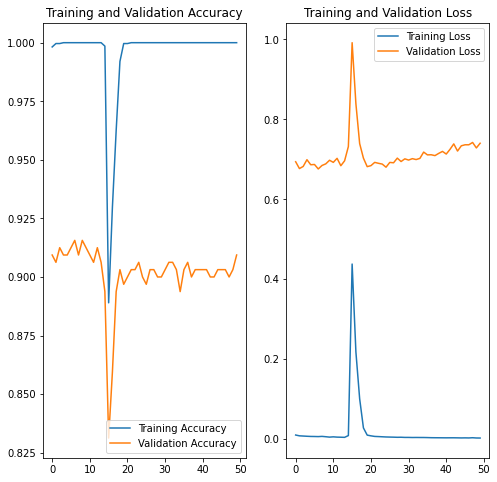

### Predictions<a href="#Predictions" class="anchor-link">¶</a>

In \[94\]:

    import numpy as np
    for images_batch, labels_batch in test_ds.take(1):
        
        first_image = images_batch[0].numpy().astype('uint8')
        first_label = labels_batch[0].numpy()
        
        print("first image to predict")
        plt.imshow(first_image)
        print("actual label:",class_names[first_label])
        
        batch_prediction = model.predict(images_batch)
        print("predicted label:",class_names[np.argmax(batch_prediction[0])])

    first image to predict
    actual label: Healthy
    predicted label: Healthy

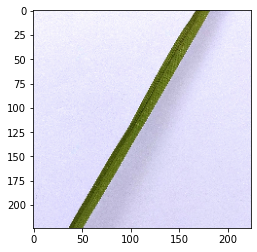

In \[95\]:

    def predict(model, img):
        img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)

        predicted_class = class_names[np.argmax(predictions[0])]
        confidence = round(100 * (np.max(predictions[0])), 2)
        return predicted_class, confidence

In \[98\]:

    plt.figure(figsize=(15, 15))
    for images, labels in test_ds.take(2):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            predicted_class, confidence = predict(model, images[i].numpy())
            actual_class = class_names[labels[i]] 
            
            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
            
            plt.axis("off")

    <ipython-input-98-2c2b6b3c3b29>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
      ax = plt.subplot(3, 3, i + 1)

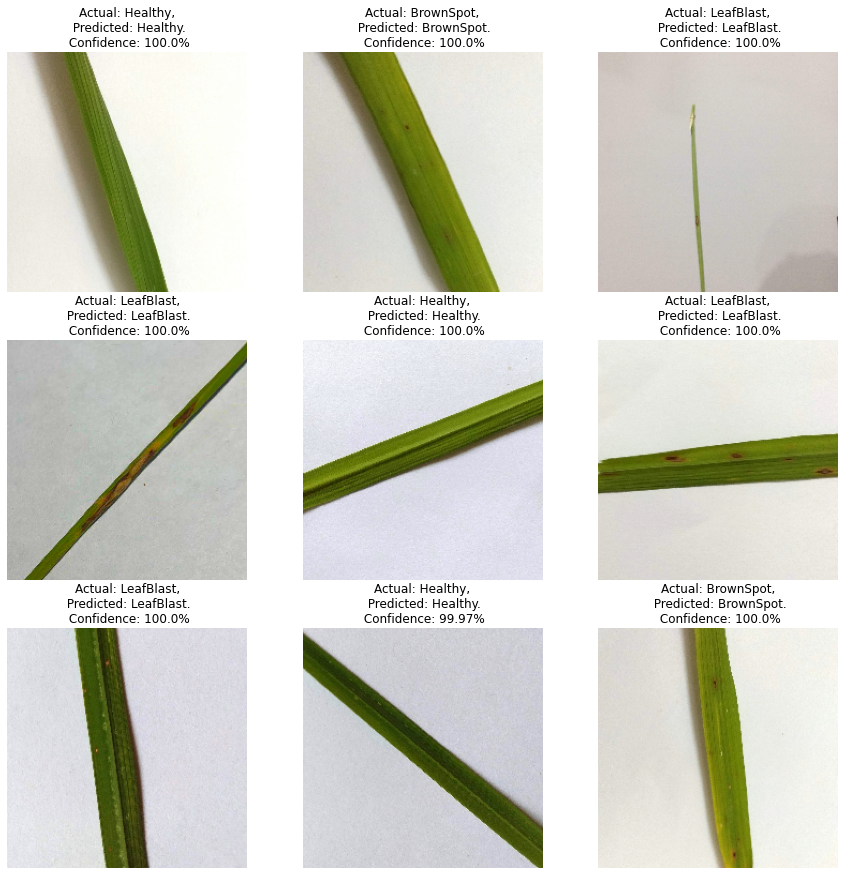

### Save the Model<a href="#Save-the-Model" class="anchor-link">¶</a>

In \[97\]:

    import os
    model.save("mobilenetv3large")

    INFO:tensorflow:Assets written to: mobilenetv3large\assets

    INFO:tensorflow:Assets written to: mobilenetv3large\assets

In \[ \]: